For each timespan, do multiple sequence alignment between the clades to see any differences between them all

In [6]:
import pandas as pd
import os

project_dir = os.path.join('..', '..')

In [7]:
df = pd.read_csv(os.path.join(project_dir, 'data', 'final', 'all.csv'))
df.head()

,state,p_sequence,p_accession,date,count,n_accession,n_sequence,clade,timespan
0,MA,"""MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRS...",QTP71261,2020,2,MW885877,GGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTA...,20A,1
1,WA,"""MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRS...",QLJ57227,2020,1367,MT252714,CTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGT...,19B,1
2,WA,"""MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRS...",QLJ57383,2020,1,MT252753,CCCTTHAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTT...,19A,1
3,CA,"""MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRS...",QHW06059,2020-01-29,2,MT027064,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...,19A,1
4,WA,"""MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRS...",QKS89879,2020-02-29,26,MT627216,TAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATC...,19B,1


In ../../data/ClustalW_Files I have created fasta files for each timespan, and for each clade chose the one with the highest count to be included in the file.

The fasta files headers include the p_acession number, for lookup in the ncbi database
and the clade label which is figured out by using nextclade

From there, we can create individual aln files for each timespan by either downloadig [clustalw](http://www.clustal.org/omega/#Download) or by running it on [EMBL-EBI](https://www.ebi.ac.uk/Tools/msa/clustalo/).

Here is how the webpage should look after uploading the file to it


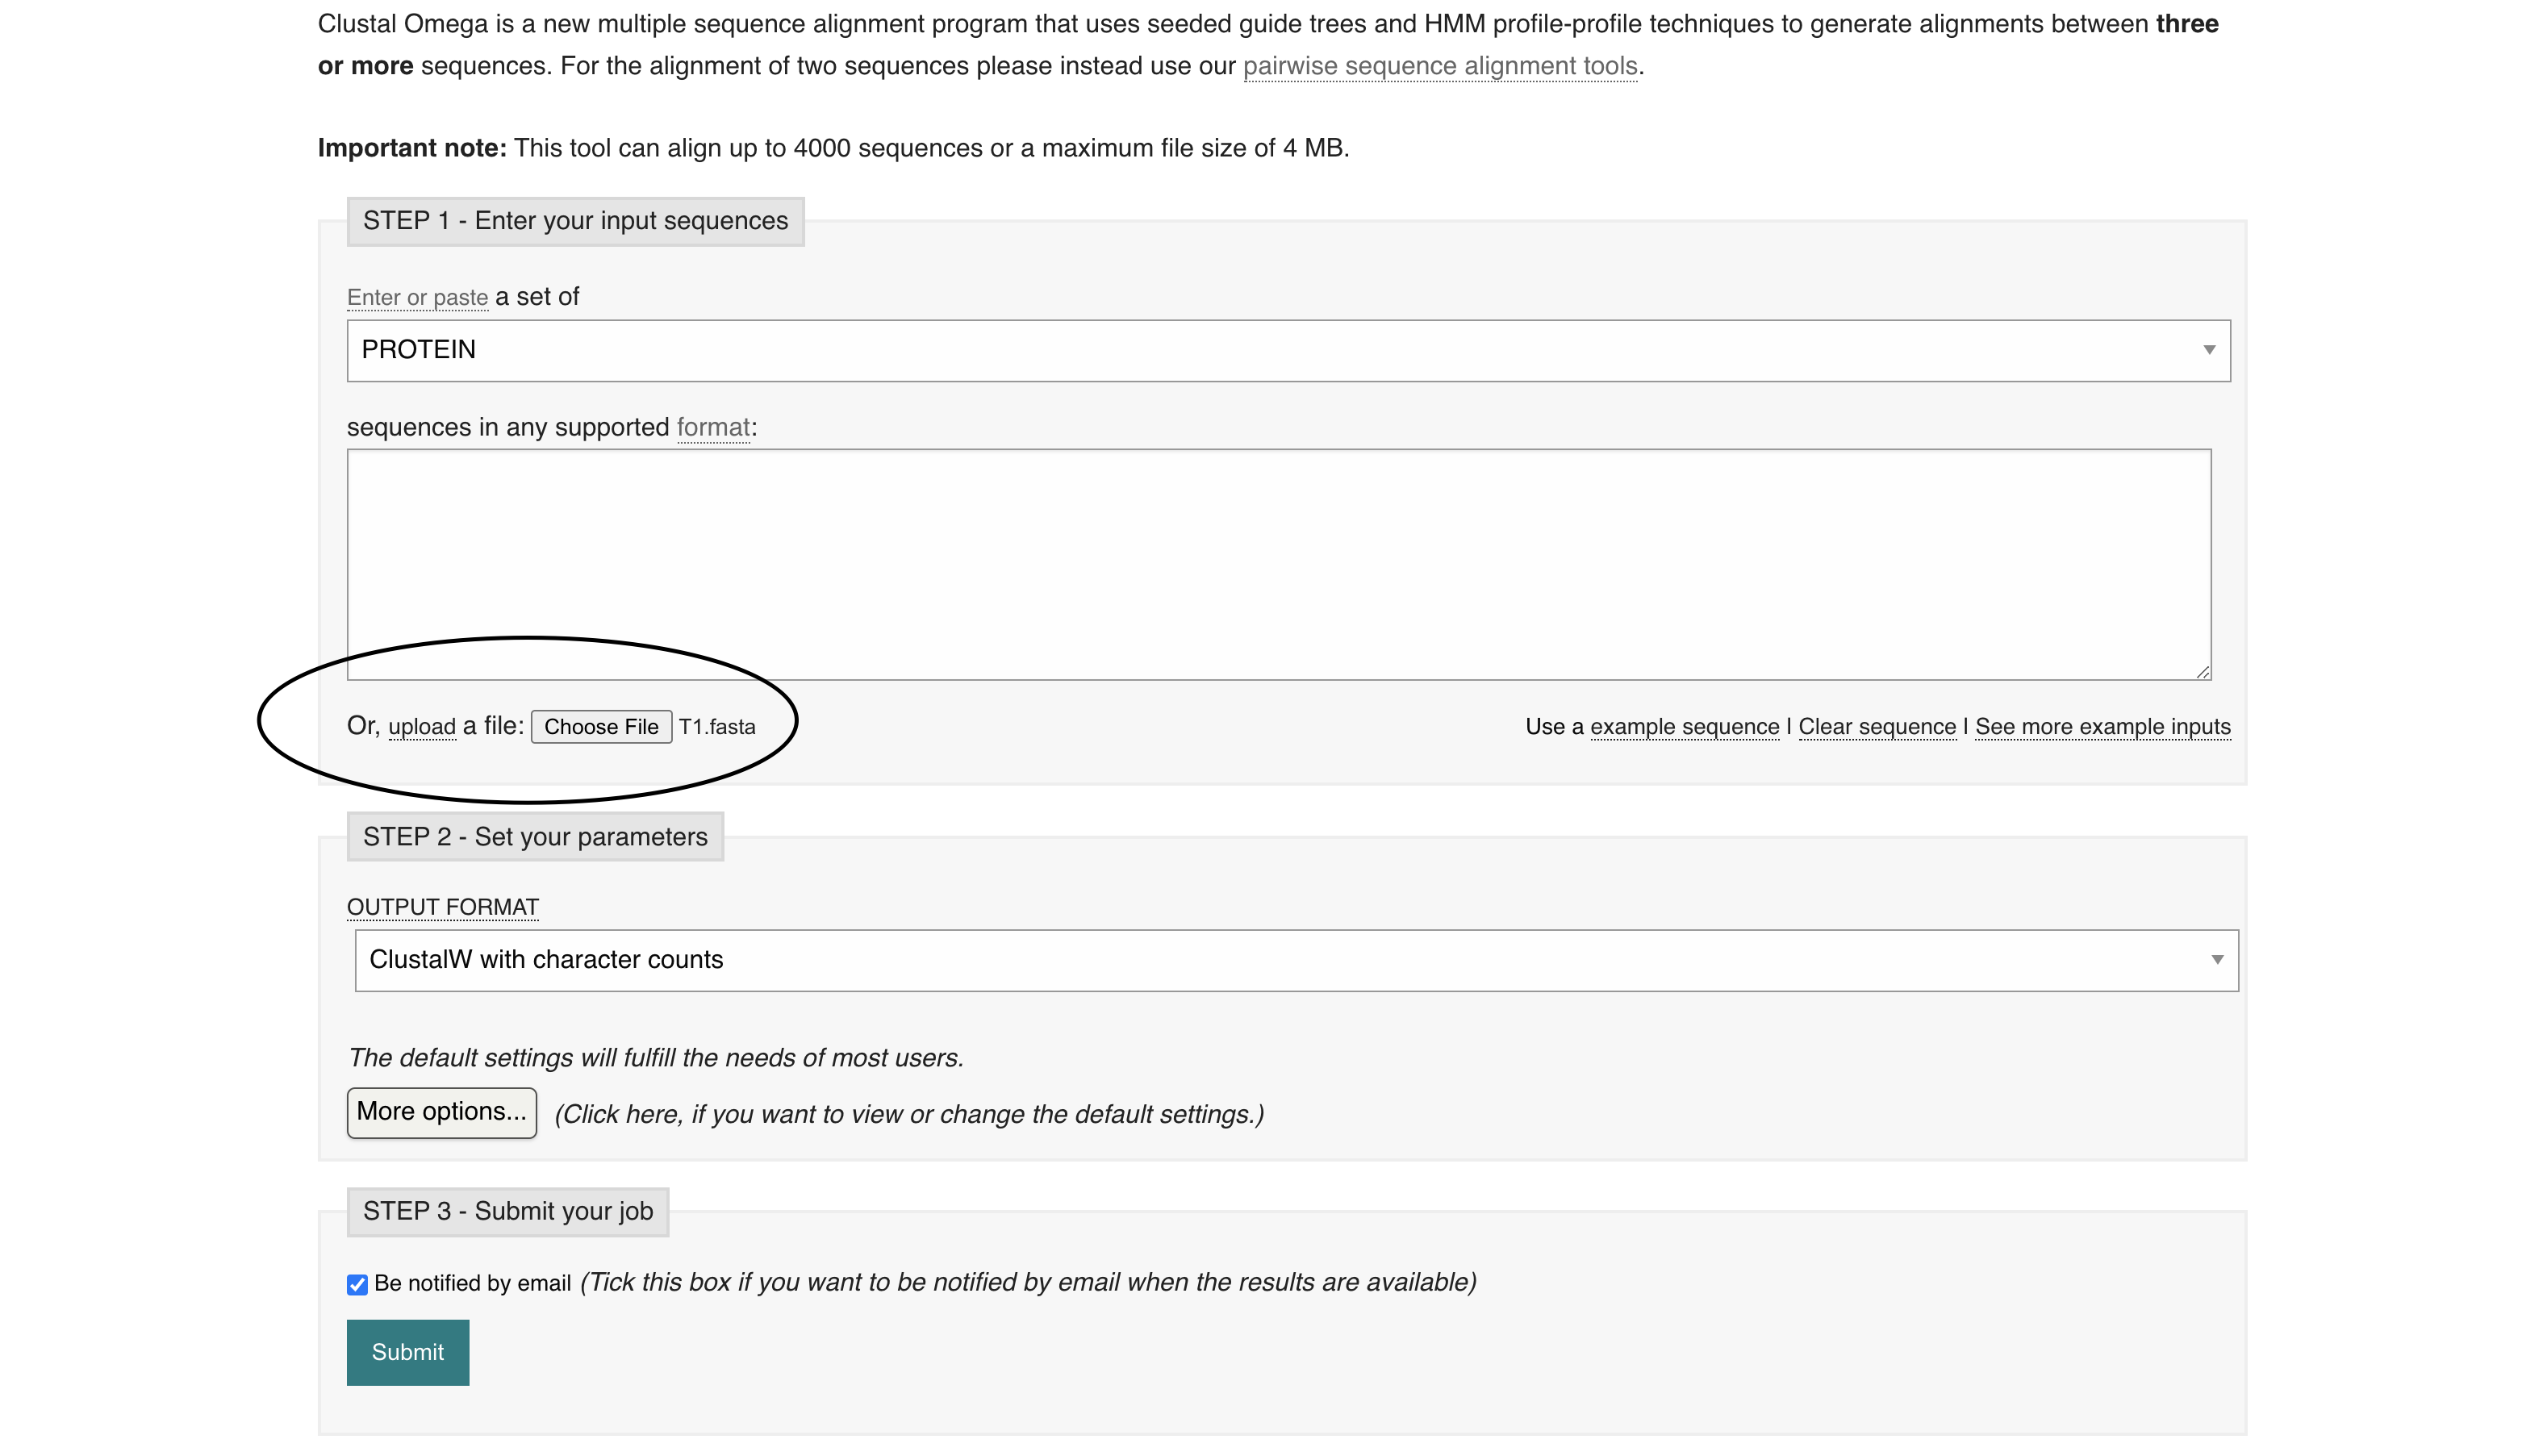

For using clustal omega directly, download the binary for your respective system at [clustal omega](http://www.clustal.org/omega/#Download)

The code below works for UNIX/MacOS Systems, mileage may vary for windows but the idea is the same

If cloning this repository you may need to chmod the binary file in src/clustalo_bin

In [8]:


from Bio.Align.Applications import ClustalwCommandline
#First tell the program where to look for the input file
in_file = os.path.join(project_dir, 'data', 'ClustalW_Files', 'Fasta', 'T1.fasta')

clustalw_cline = ClustalwCommandline("clustalw2", infile = in_file)
print(clustalw_cline)
#tell the program now where the clustalo binary is located
clustalw_exe = r"../clustalo_bin/clustalo"
clustalw_cline = ClustalwCommandline(clustalw_exe, infile = in_file, newtree = "tree.dnd")

#check if the binary path actually works before trying stuff
assert os.path.isfile(clustalw_exe), "clustalw executable is missing"

#make the output go to stdout, and stderr variables
stdout, stderr = clustalw_cline()
print(clustalw_cline)



clustalw2 -infile=../../data/ClustalW_Files/Fasta/T1.fasta
../clustalo_bin/clustalo -infile=../../data/ClustalW_Files/Fasta/T1.fasta -newtree=tree.dnd


The code above will create clustal.aln and tree.dnd for the given infile.

Moving the files into data and renaming them appropriately

In [9]:
#edit these for whatever time period you are doing

#if one runs but not the other, try commenting out whatever has already been moved
os.rename("clustal.aln", "../../data/ClustalW_Files/Alignments/T1.aln")
os.rename("tree.dnd", "../../data/ClustalW_Files/Trees/T1.dnd")


## Reading the align file

In [10]:
from Bio import AlignIO

ClustalAlign = AlignIO.read(os.path.join(project_dir, 'data', 'ClustalW_Files',
    'Alignments', 'T1.aln'), "clustal")
print(ClustalAlign)

Alignment with 5 rows and 1273 columns
MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFR...HYT 19A
MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFR...HYT 19B
MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFR...HYT 20A
MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFR...HYT 20B
MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFR...HYT 20C


Now that we have the file we can make this look a little more pretty, and actually readable. We'll do this with bokeh and panel

In [11]:
import numpy as np

import panel as pn
import panel.widgets as pnw
pn.extension()

from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Plot, Grid, Range1d
from bokeh.models.glyphs import Text, Rect
from bokeh.layouts import gridplot

def get_colors(seqs):
    text = [i for s in list(seqs) for i in s]
    clrs = {'A': 'red', 'T': 'green', 'G':'orange', 'C':'blue', '-' : 'white', 
        'M': 'purple',  'F': 'cyan', 'V': 'grey', 'L': 'yellow', 'P':'pink',
        'S': 'violet', 'Q': 'darkorchid', 'N': 'brown', 'R': 'crimson',
        'Y': 'goldenrod', 'D': 'lightblue', 'K': 'darkorange', 'W': 'salmon',
        'H':'deeppink', 'I':'royalblue', 'E':'chartreuse'}
    colors = [clrs[i] for i in text]
    return colors
    
#function adapted from https://dmnfarrell.github.io/bioinformatics/bokeh-sequence-aligner
def view_aln(aln, fontsize="9pt", plot_width=800):
    #sequence and id lists from .aln file
    seqs = [rec.seq for rec in (aln)]
    ids = [rec.id for rec in aln]
    text = [i for s in list(seqs) for i in s]
    
    colors = get_colors(seqs)
    N = len(seqs[0])
    S = len(seqs)

    width = .4

    #set axis
    x = np.arange(1, N+1)
    y = np.arange(0, S, 1)
    #create 2D grid of coordinates from our 1D array
    xx, yy = np.meshgrid(x, y)
    #flatten arrays
    gx = xx.ravel()
    gy = yy.flatten()
    #use recty for rect coordinates with offset
    recty = gy+.5
    h = 1/S

    #now create the ColumnDataSource with all our arrays
    source = ColumnDataSource(dict(x=gx,
        y=gy, recty=recty, text=text, colors=colors))
    plot_height = len(seqs)*15+50
    xrange = Range1d(0, N+1, bounds='auto')

    if N>100:
        viewlen=100
    else:
        viewlen=N
    #view range is for the up close views
    view_range = (0, viewlen)
    tools = "xpan, xwheel_zoom, reset, save"

    #entire sequence view, no text with zoom
    p = figure(title = None, plot_width = plot_width, plot_height=50, 
        x_range=xrange, y_range=(0,S), tools=tools, min_border=0, 
        toolbar_location='below')
    rects = Rect(x='x', y='recty', width=1, height=1, fill_color='colors',
        line_color=None, fill_alpha=0.6)
    p.add_glyph(source, rects)
    p.yaxis.visible = False
    p.grid.visible = False

    #sequence text view with ability to scroll along x axis
    p1 = figure(title=None, plot_width=plot_width, plot_height=plot_height,
        x_range=view_range, y_range=ids, tools="xpan, reset", 
        min_border=0, toolbar_location='below')
    glyph = Text(x="x", y="y", text="text", text_align='center', text_color="black",
        text_font="monospace", text_font_size=fontsize)
    rects = Rect(x="x", y="recty", width=1, height=1, fill_color="colors",
        line_color=None, fill_alpha=0.4)
    
    p1.add_glyph(source, glyph)
    p1.add_glyph(source, rects)

    p1.grid.visible = False
    p1.xaxis.major_label_text_font_style = "bold"
    p1.yaxis.minor_tick_line_width = 0
    p1.yaxis.major_tick_line_width = 0

    p = gridplot([[p], [p1]], toolbar_location='below')
    return p


In [12]:
aln = AlignIO.read(os.path.join(project_dir, 'data', 'ClustalW_Files',
    'Alignments', 'T1.aln'), 'clustal')
p = view_aln(aln, plot_width=900)
pn.pane.Bokeh(p)

Bokeh(Column)

Running the above code will give a interactive output seen in the image below

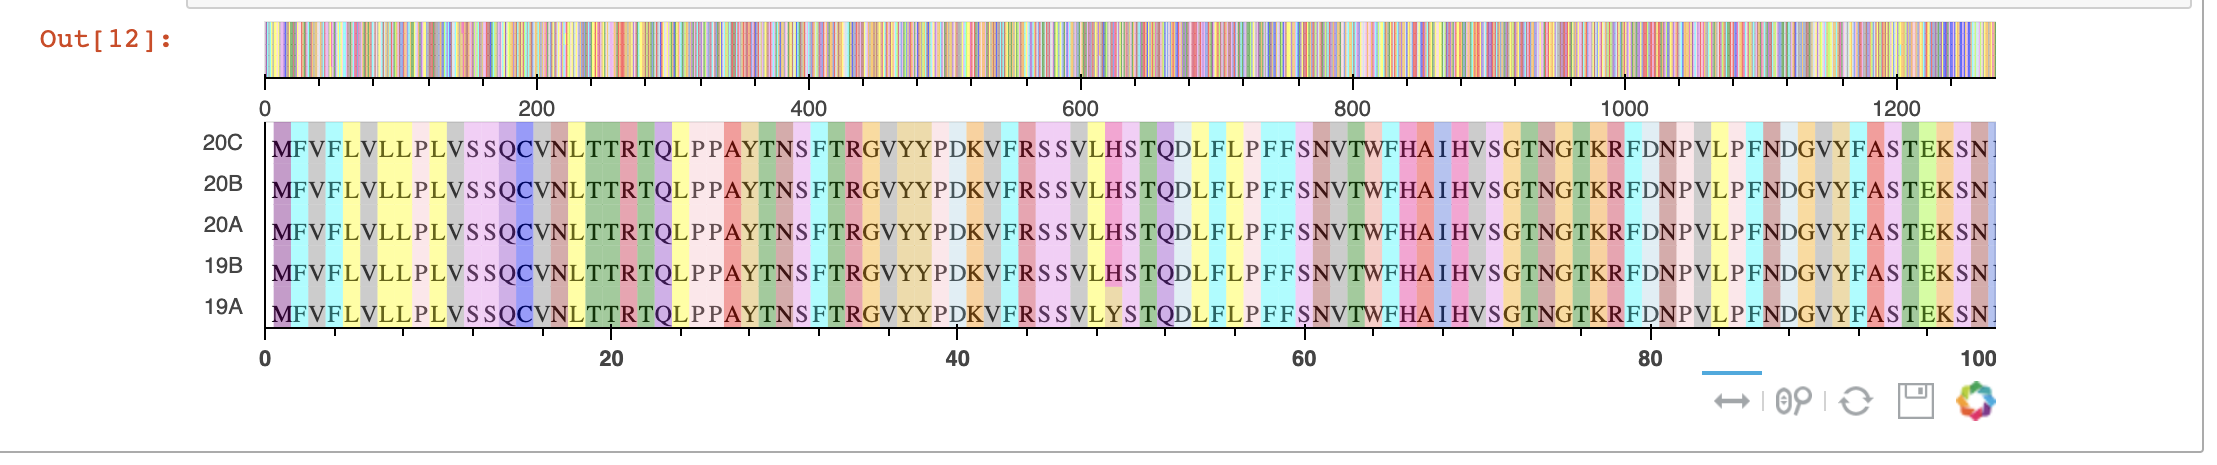

## Reading the dnd file
Which basically gives us a phylogenetic tree, more similar sequences will be children on parent branches

In [ ]:
from Bio import Phylo

tree = Phylo.read(os.path.join(project_dir, 'data', 'ClustalW_Files',
    'Trees', 'T1.dnd'), 'newick')
Phylo.draw_ascii(tree)

  _______________________________________________________________________ 20C
_|
_________________________________________________________________________ __ 20B
 |                                                                       |
____________________________________________________________________________ 20A
                                                                 |       |
                                        __________________________________ 19A
_______________________________________|                         |__________
                                       |__________________________________ 19B

